# Machine Learning Application: Multifidelity Climate Modelling 
17 November 2022

![](https://raw.githubusercontent.com/scotthosking/mf_modelling/main/images/mf_setup.png)

## Introduction
In this notebook we will analyse monthly averaged output from two weather/climate model simulators which both span the same period (1980-01, to 2018-12) and regions (Peru, South America). These outputs are:
1. A region extracted from a global climate model simulator (Fig. a above). We will refer to this as the 'low-fidelity' dataset
2. A high-resolution Regional Climate Model (RCM) simulator (Fig. b above) which was updated at the lateral boundaries every one hour with data from the global climate model (i.e., that shown in Fig. a). Inside the RCM spatial domain, the atmosphere is free-running following the RCM's own physics equations (i.e., the RCM is not constrained by the global climate model at grid-points away from the RCM's lateral boundaries). We will refer to this as the 'high-fidelity' dataset.

The surface conditions (soil temperature, moisture, snow cover, etc.) in both simulators are prescribed and updated over time. As the RCM was updated at the lateral boundaries from the global climate model, we can assume that large-scale climate variability are synchronised in time across the two datasets. 

### The Challenge
As we know the gridded terrain height/elevation map from the high-fidelity model (which we assume does not change over time), and the gridded temperature and winds of the low-fidelity model, can we make temperature predictions over the mountainous regions over Peru?

### Simulation data glossary:
  * 'hgt': Terrain height (high-fidelity only)
  * 't2m': Near-surface temperature data (low- and high-fidelity data)
  * 'u10', 'v10': East-ward & north-ward winds (low-fidelity only)

### Other useful information:
* See GitHub repo for more info: https://github.com/scotthosking/mf_modelling
* See [Xarray documentation](http://xarray.pydata.org/en/stable/)

# Tasks

## Task 1: Download and prepare the required data
First, run the below code so you have the data needed to complete the main task.

In [1]:
! pip install --upgrade xarray cftime nc-time-axis dask
! pip install netcdf4

  Using cached xarray-2022.11.0-py3-none-any.whl (963 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.6/212.6 kB 966.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.0 MB/s eta 0:00:0000:0100:010m


In [3]:
### Download files from github repo
!wget https://github.com/scotthosking/mf_modelling/raw/main/data/hifid_hgt.nc -O hifid_hgt.nc
!wget https://github.com/scotthosking/mf_modelling/raw/main/data/hifid_t2m_monthly.nc -O hifid_t2m_monthly.nc
!wget https://github.com/scotthosking/mf_modelling/raw/main/data/lofid_t2m_monthly.nc -O lofid_t2m_monthly.nc
!wget https://github.com/scotthosking/mf_modelling/raw/main/data/lofid_u10_monthly.nc -O lofid_u10_monthly.nc
!wget https://github.com/scotthosking/mf_modelling/raw/main/data/lofid_v10_monthly.nc -O lofid_v10_monthly.nc

--2022-12-02 10:17:10--  https://github.com/scotthosking/mf_modelling/raw/main/data/hifid_hgt.nc
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/scotthosking/mf_modelling/main/data/hifid_hgt.nc [following]
--2022-12-02 10:17:11--  https://raw.githubusercontent.com/scotthosking/mf_modelling/main/data/hifid_hgt.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45657 (45K) [application/octet-stream]
Saving to: ‘hifid_hgt.nc’

hifid_hgt.nc        100%[===================>]  44.59K  --.-KB/s    in 0.07s   

2022-12-02 10:17:11 (612 KB/s) - ‘hifid_hgt.nc’ saved [45657/45657]

--2022-1

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [82]:
### load datasets
hi_ds = xr.open_mfdataset('hifid*.nc').load()
lo_ds = xr.open_mfdataset('lofid*.nc').load()

#Lets clip the hi-resolution dataset to 80x80 we can use CNNs more easily (if you wish).
hi_ds = hi_ds.isel(latitude=slice(5, 85), longitude=slice(7, 87))

In [6]:
hi_ds

<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 80, time: 468)
Coordinates:
  * latitude   (latitude) float32 -10.64 -10.61 -10.57 ... -7.859 -7.823 -7.787
  * longitude  (longitude) float32 280.8 280.8 280.9 280.9 ... 283.6 283.6 283.7
  * time       (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2018-12-31
Data variables:
    hgt        (latitude, longitude) float32 0.0 0.0 0.0 ... 995.7 984.1 970.5
    t2m        (time, latitude, longitude) float32 19.58 19.59 ... 20.99 20.75
Attributes:
    Description:  High Fidelity Climate Model Output

In [7]:
lo_ds

<xarray.Dataset>
Dimensions:    (time: 468, latitude: 54, longitude: 52)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2018-12-31
  * latitude   (latitude) float32 -2.5 -2.75 -3.0 -3.25 ... -15.25 -15.5 -15.75
  * longitude  (longitude) float32 275.8 276.0 276.2 276.5 ... 288.0 288.2 288.5
Data variables:
    t2m        (time, latitude, longitude) float32 23.96 23.89 ... 6.706 6.403
    u10        (time, latitude, longitude) float32 -1.278 -1.132 ... 0.7329
    v10        (time, latitude, longitude) float32 4.373 4.441 ... 0.9814 0.8796
Attributes:
    Description:  Low Fidelity Climate Model Output

### Interpolate
There are many ways you could feed your low-fidelity data into your model. However, the most simple way would be to first interpolate it to the same grid.

In [8]:
lo_ds_interp = lo_ds.interp(latitude=hi_ds.latitude, longitude=hi_ds.longitude)

Move the topo into lo_ds_interp, as we need it for training.

In [9]:
lo_ds_interp['hgt'] = hi_ds['hgt'] 
del hi_ds['hgt'] 

### Visulations

(array([2089.,  444.,  325.,  335.,  427.,  563.,  956.,  981.,  259.,
          21.]),
 array([   0.    ,  562.7295, 1125.459 , 1688.1885, 2250.918 , 2813.6475,
        3376.377 , 3939.1064, 4501.836 , 5064.5654, 5627.295 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

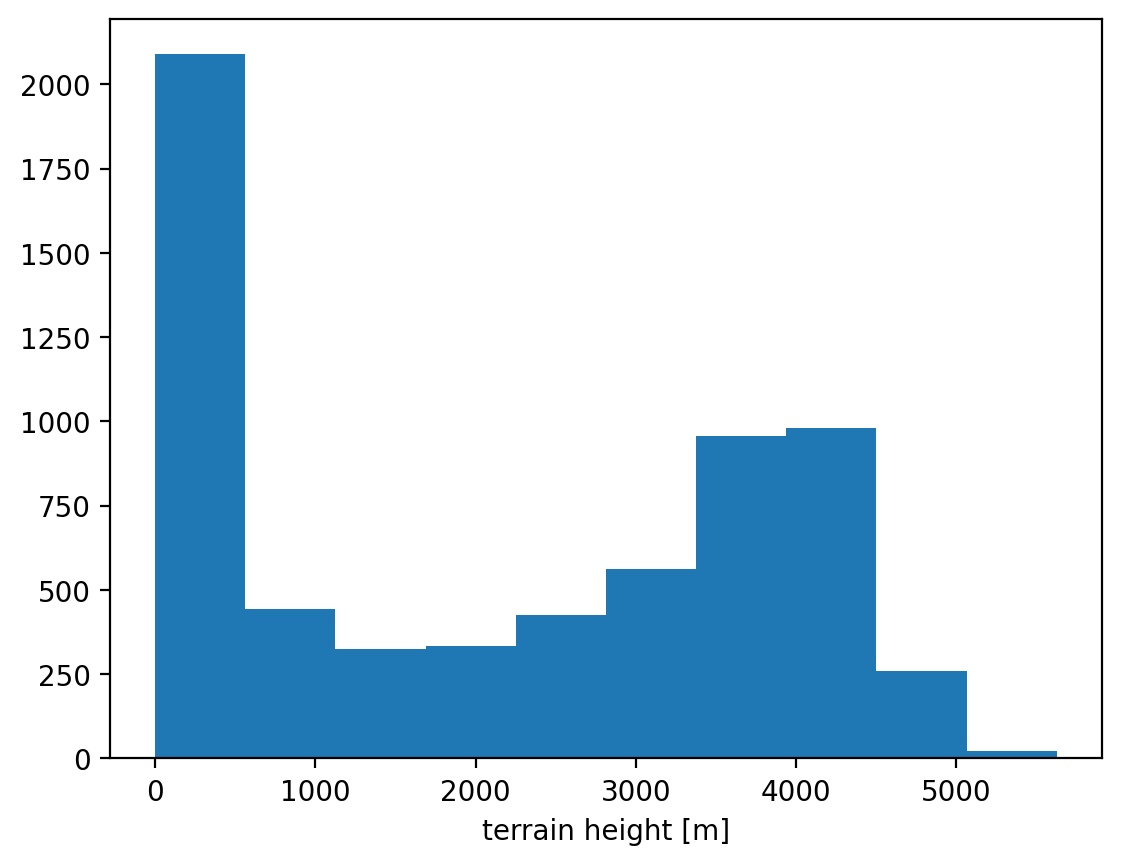

In [10]:
### Lets see the range of elevations within the high-fidelity model, and use this to set the levels in the map below
lo_ds_interp.hgt.plot.hist()

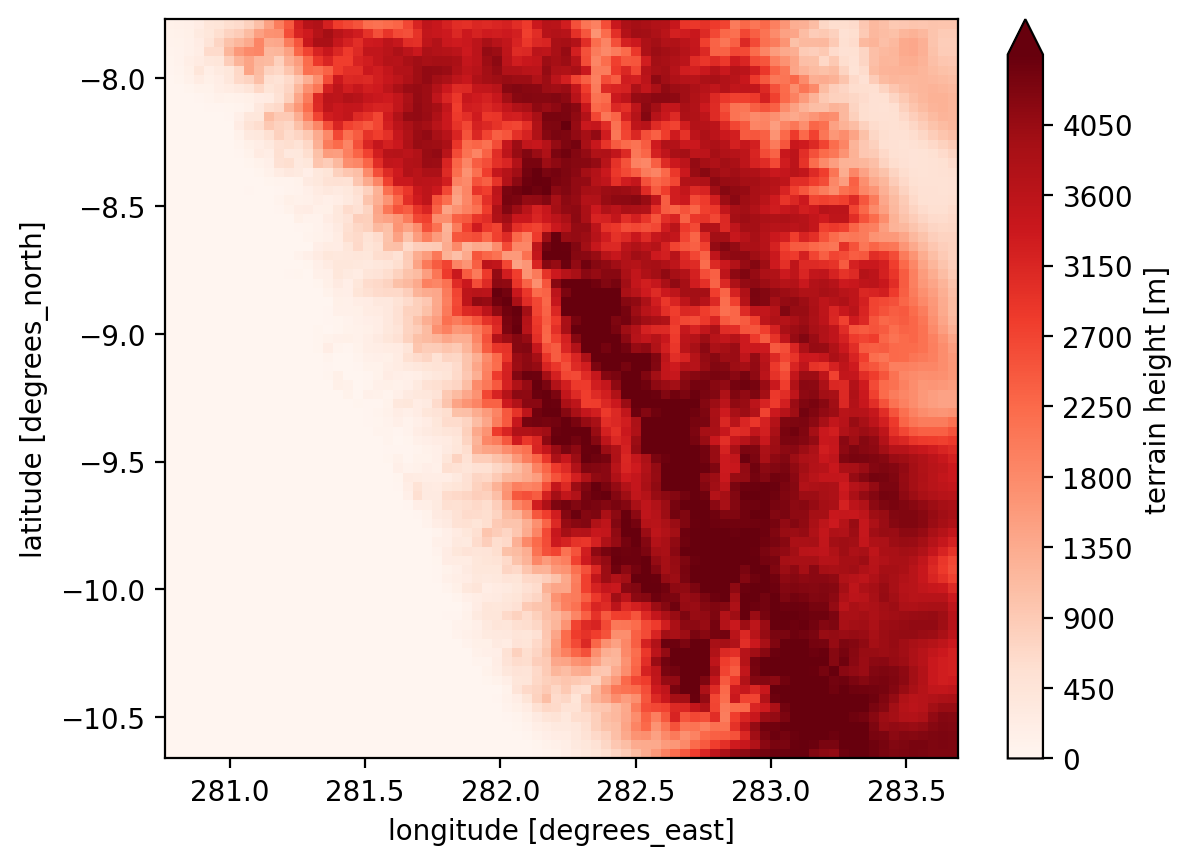

In [11]:
lo_ds_interp.hgt.plot(cmap="Reds", levels=range(0,4500))

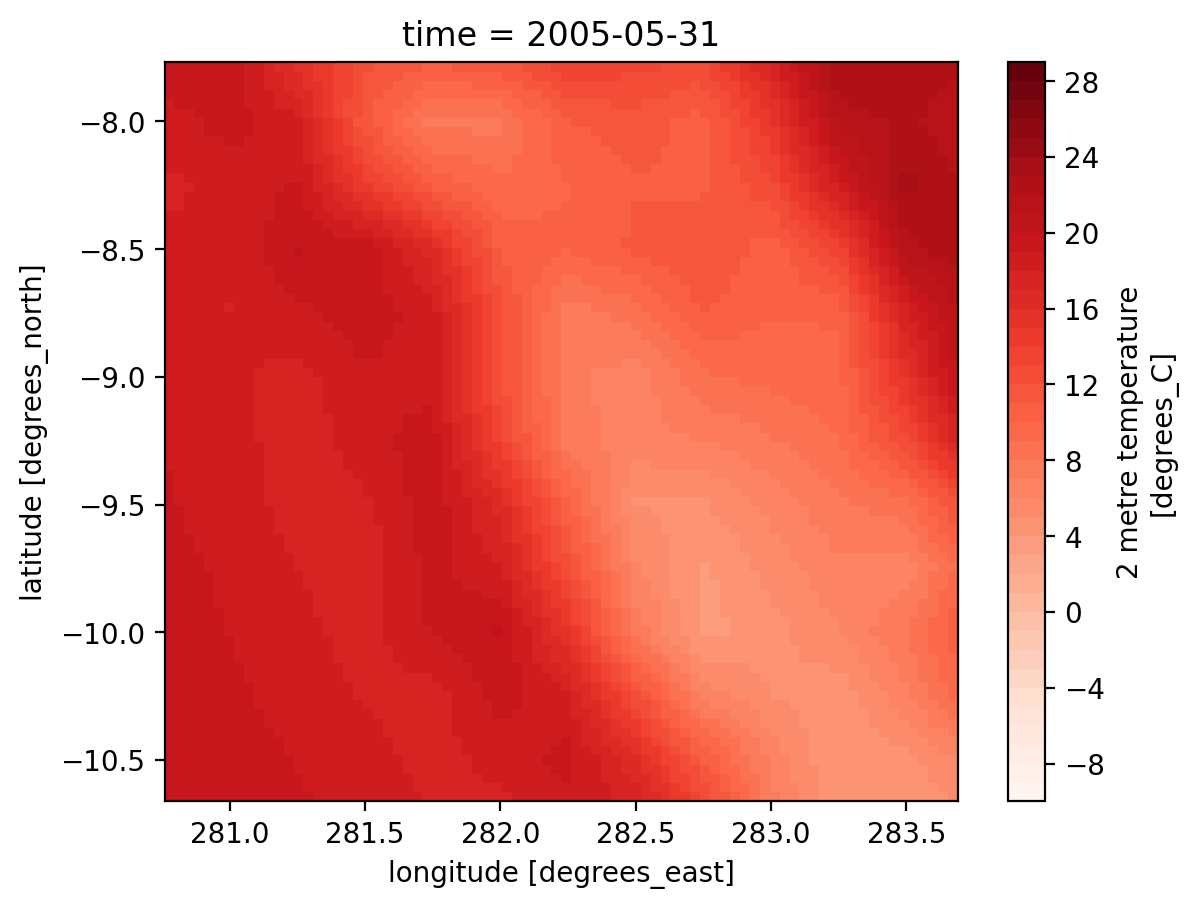

In [12]:
lo_ds_interp.t2m.sel(time="2005-05").plot(cmap="Reds", levels=range(-10,30))

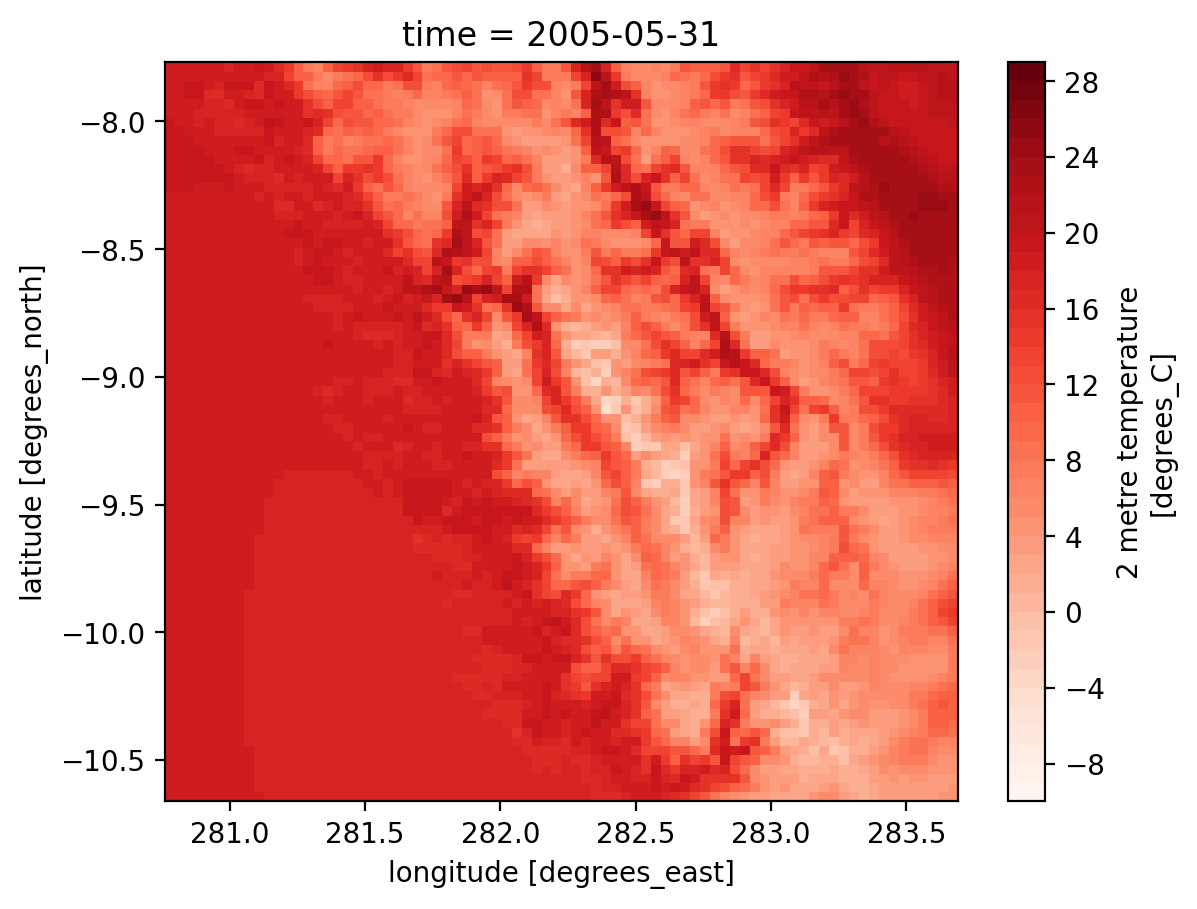

In [13]:
hi_ds.t2m.sel(time="2005-05").plot(cmap="Reds", levels=range(-10,30))

### Now split the dataset, into training and validation using the following code

In [14]:
# Split the dataset in two using the dates
valid_mask = hi_ds.time >= np.datetime64('2014-01-01')

# Validation dataset (model input)
lo_ds_valid = lo_ds_interp.isel(time=valid_mask)

# Validation targets (t2m).
hi_ds_valid = hi_ds.isel(time=valid_mask)

# Training dataset (model input)
lo_ds_train = lo_ds_interp.isel(time=~valid_mask)

# Training targets (t2m)
hi_ds_train = hi_ds.isel(time=~valid_mask)

# Display the length of the datasets
len(hi_ds_train.time), len(lo_ds_valid.time)

(408, 60)

In [17]:
lo_ds_train


<xarray.Dataset>
Dimensions:    (time: 408, latitude: 80, longitude: 80)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2013-12-31
  * latitude   (latitude) float32 -10.64 -10.61 -10.57 ... -7.859 -7.823 -7.787
  * longitude  (longitude) float32 280.8 280.8 280.9 280.9 ... 283.6 283.6 283.7
Data variables:
    t2m        (time, latitude, longitude) float32 22.85 22.81 ... 23.03 22.95
    u10        (time, latitude, longitude) float32 -2.306 -2.312 ... 0.06863
    v10        (time, latitude, longitude) float32 4.747 4.747 ... -0.463
    hgt        (latitude, longitude) float32 0.0 0.0 0.0 ... 995.7 984.1 970.5
Attributes:
    Description:  Low Fidelity Climate Model Output

In [18]:
print(type(lo_ds_train))

<class 'xarray.core.dataset.Dataset'>


In [19]:
lo_ds_train.keys()



KeysView(<xarray.Dataset>
Dimensions:    (time: 408, latitude: 80, longitude: 80)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2013-12-31
  * latitude   (latitude) float32 -10.64 -10.61 -10.57 ... -7.859 -7.823 -7.787
  * longitude  (longitude) float32 280.8 280.8 280.9 280.9 ... 283.6 283.6 283.7
Data variables:
    t2m        (time, latitude, longitude) float32 22.85 22.81 ... 23.03 22.95
    u10        (time, latitude, longitude) float32 -2.306 -2.312 ... 0.06863
    v10        (time, latitude, longitude) float32 4.747 4.747 ... -0.463
    hgt        (latitude, longitude) float32 0.0 0.0 0.0 ... 995.7 984.1 970.5
Attributes:
    Description:  Low Fidelity Climate Model Output)

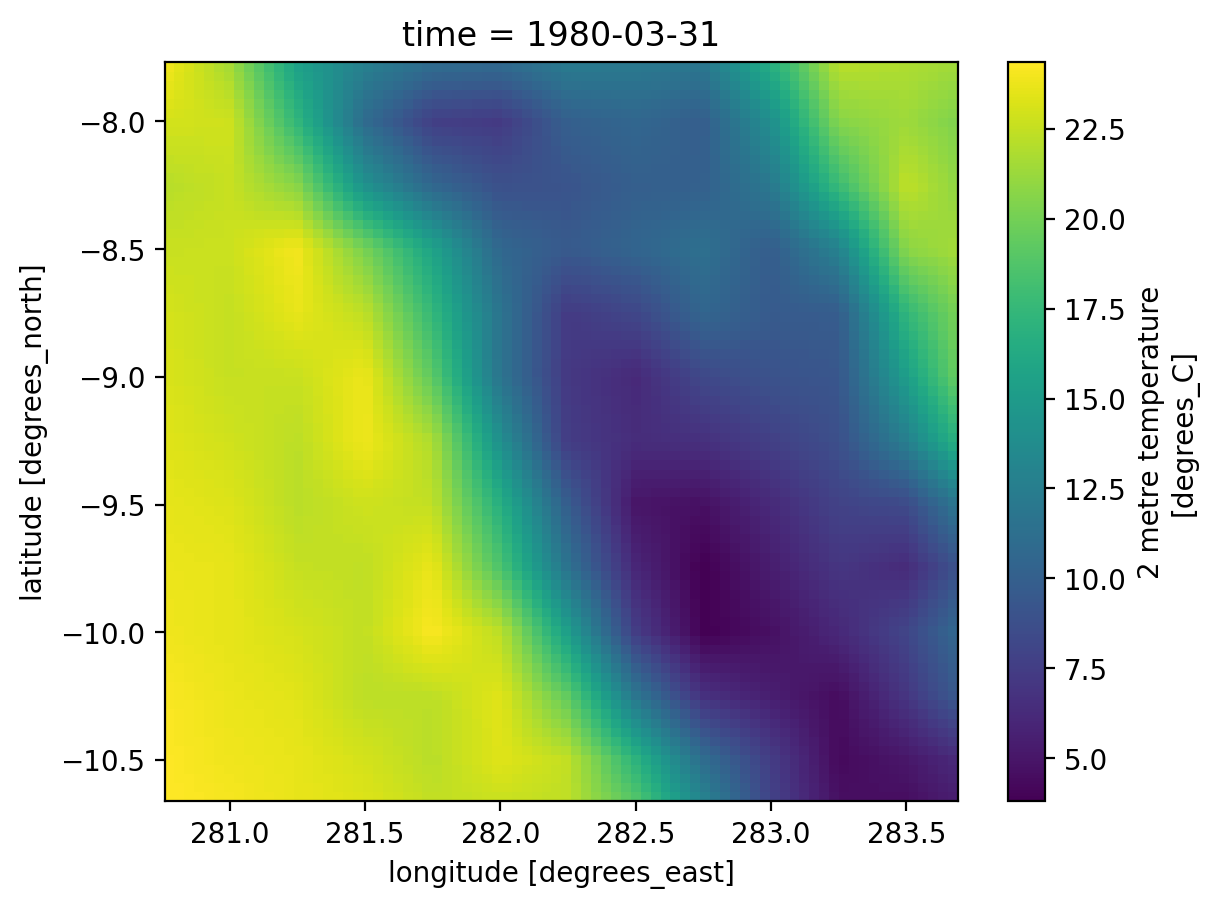

In [20]:
lo_ds_train.t2m[2].plot()

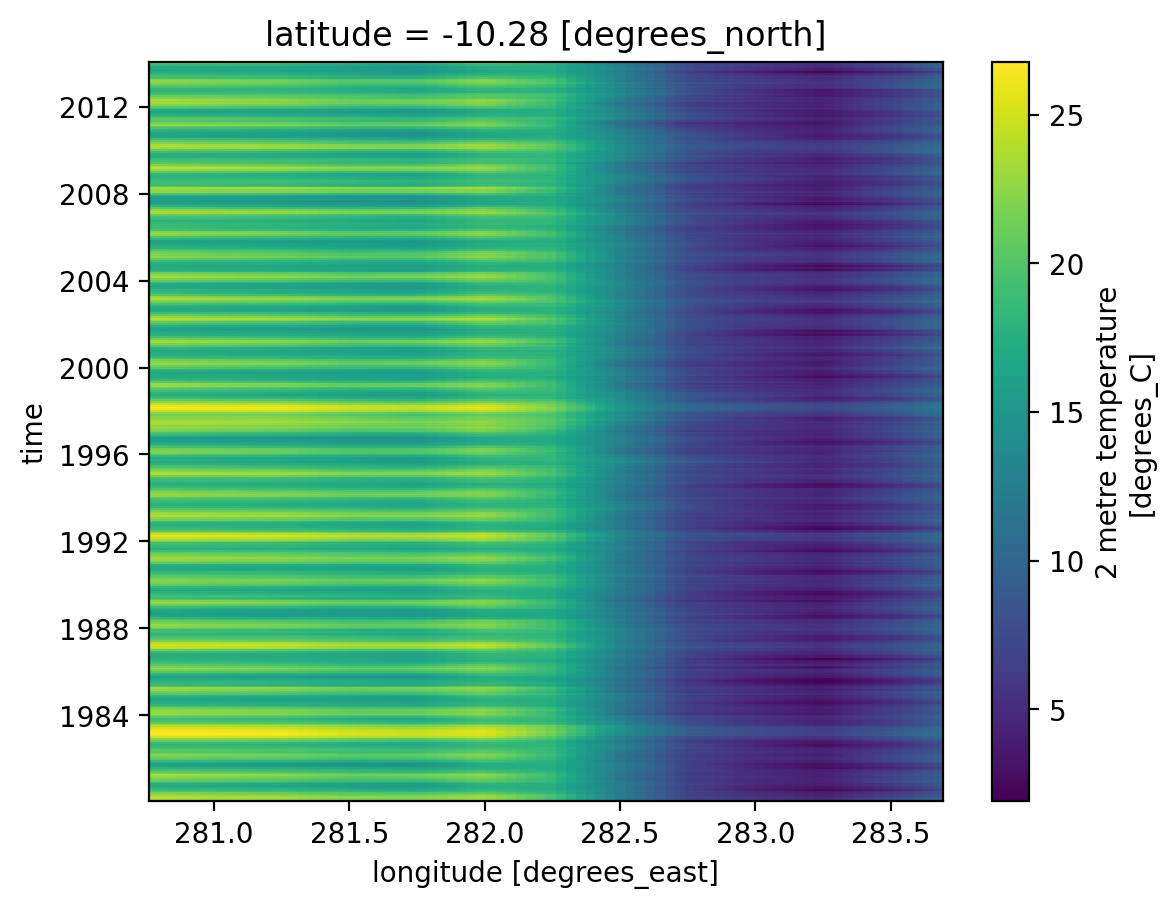

In [22]:
lo_ds_train.t2m[:, 10].plot()

(array([ 1126.,  7736., 11165., 14153., 10483.,  5630., 16989., 15888.,
         9716.,  3114.]),
 array([ 1.8015122,  4.027234 ,  6.2529564,  8.478679 , 10.704401 ,
        12.930122 , 15.155845 , 17.381567 , 19.607288 , 21.833012 ,
        24.058733 ], dtype=float32),
 <BarContainer object of 10 artists>)

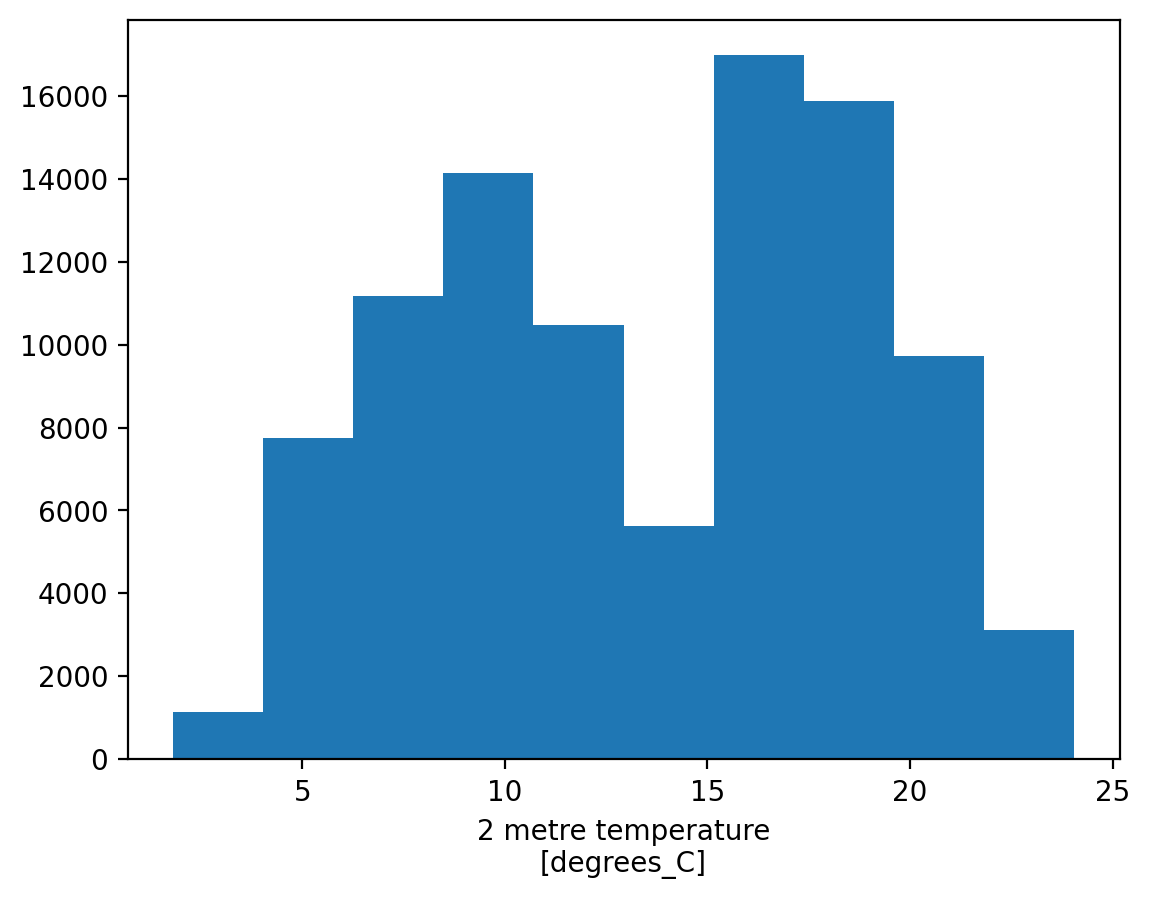

In [52]:
lo_ds_train.t2m.sel(time=slice('2012-10-01', '2018-12-01')).plot()

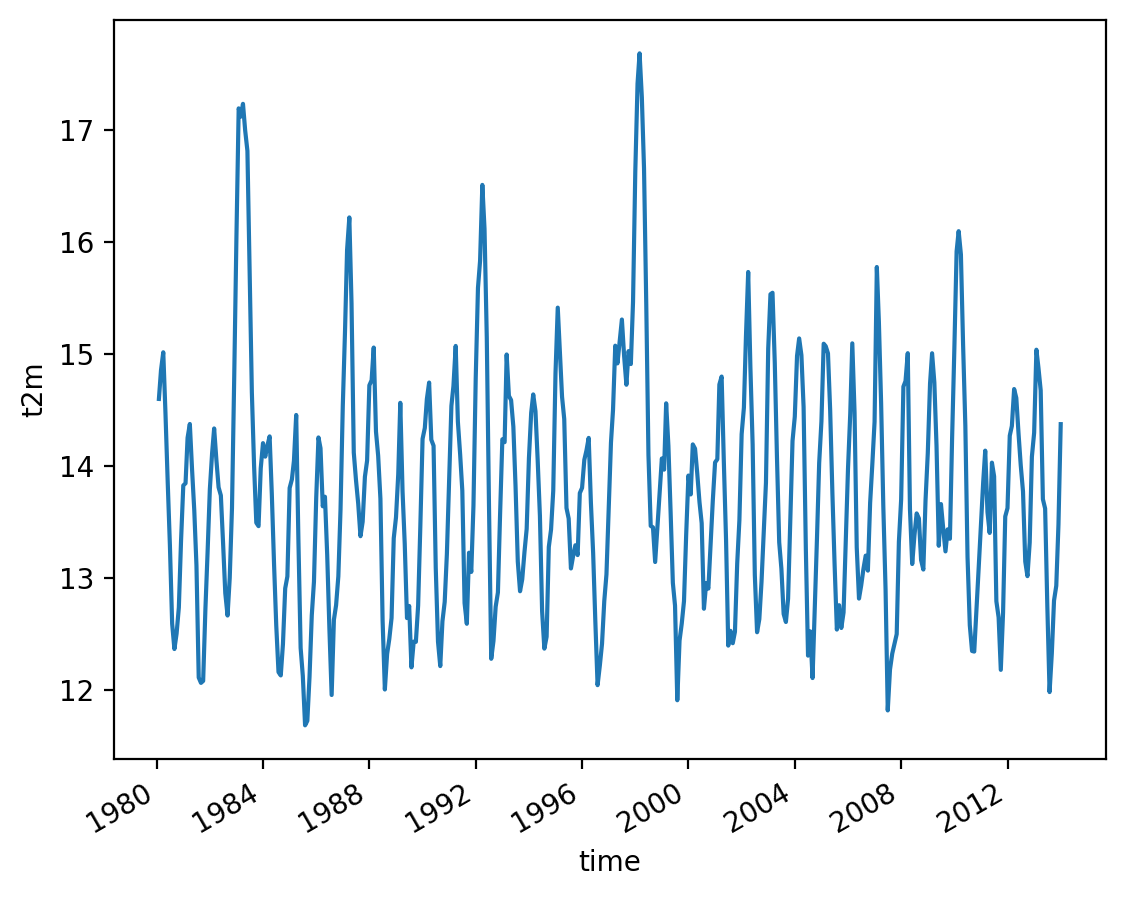

In [27]:
lo_ds_train.t2m.mean(dim=('longitude', 'latitude')).plot()

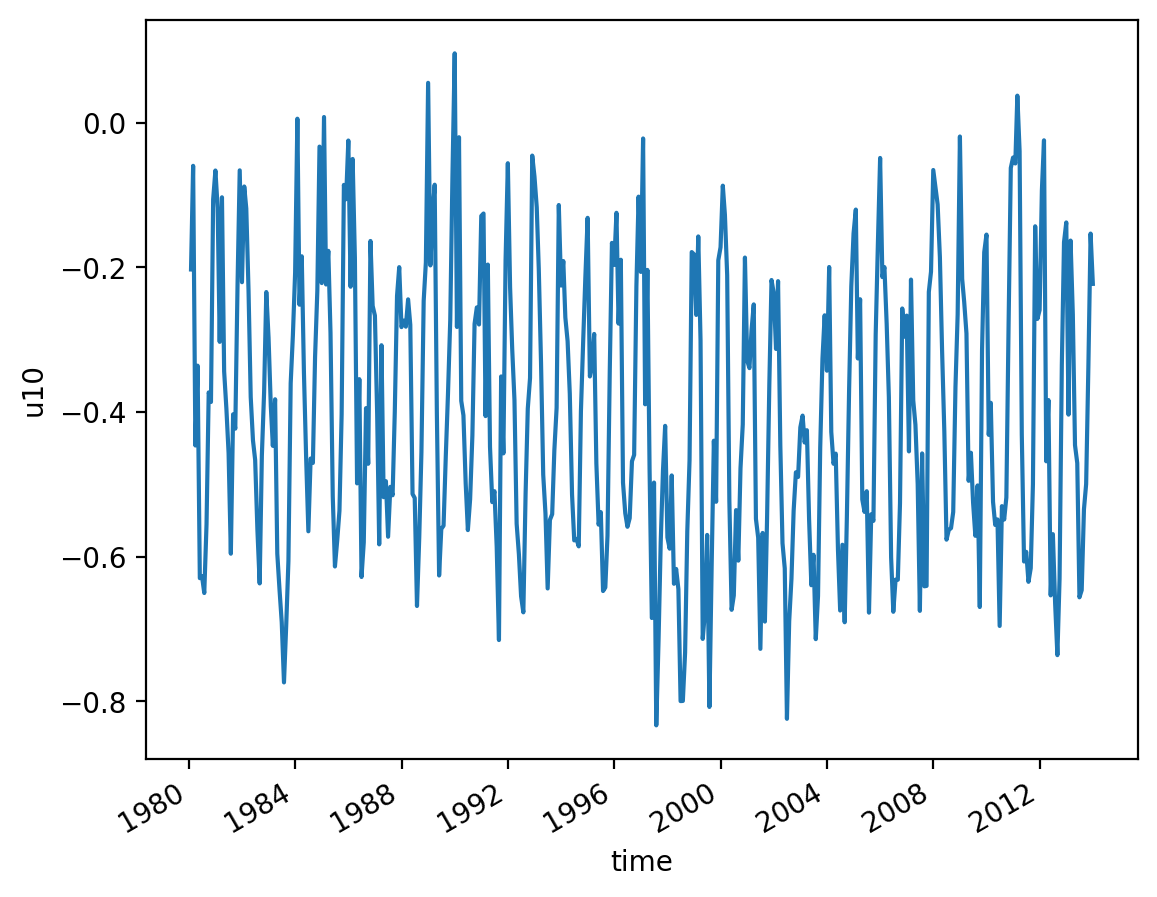

In [31]:
lo_ds_train.u10.mean(dim=('longitude', 'latitude')).plot()

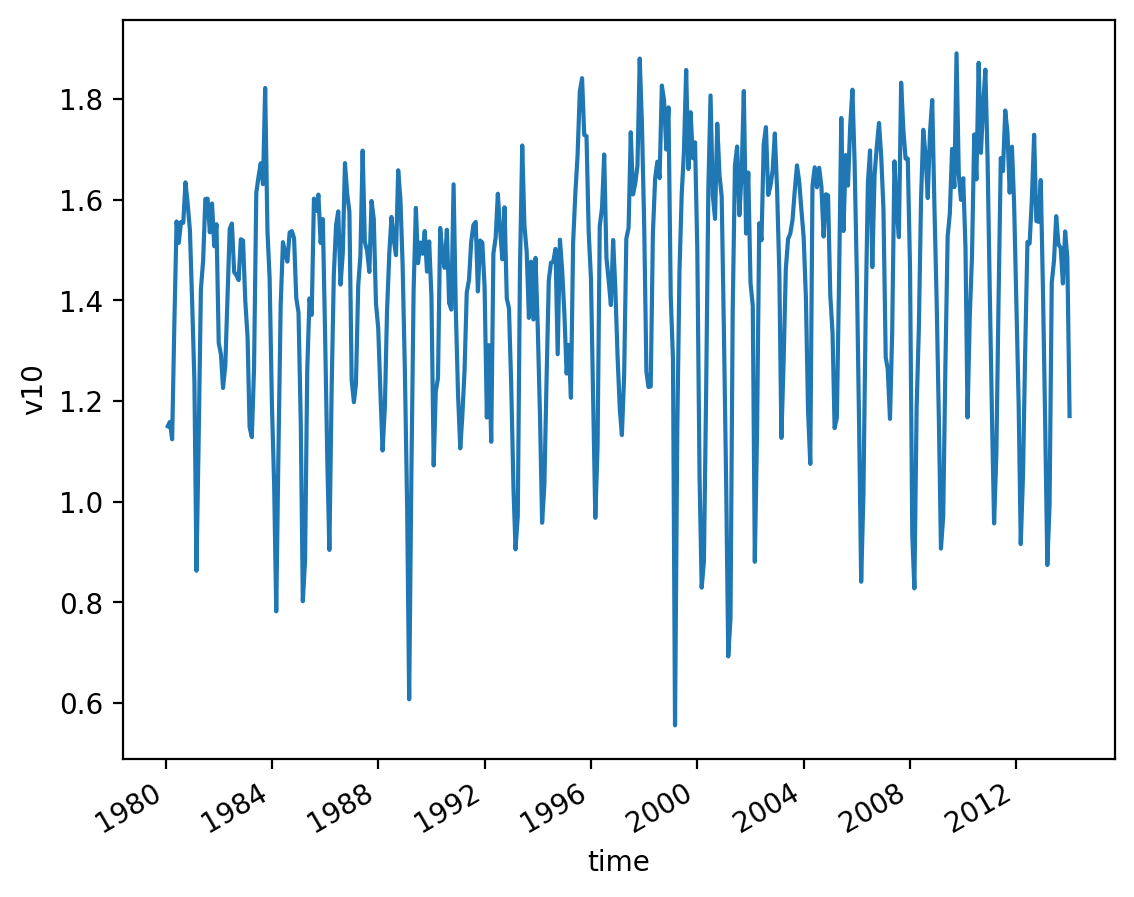

In [32]:
lo_ds_train.v10.mean(dim=('longitude', 'latitude')).plot()

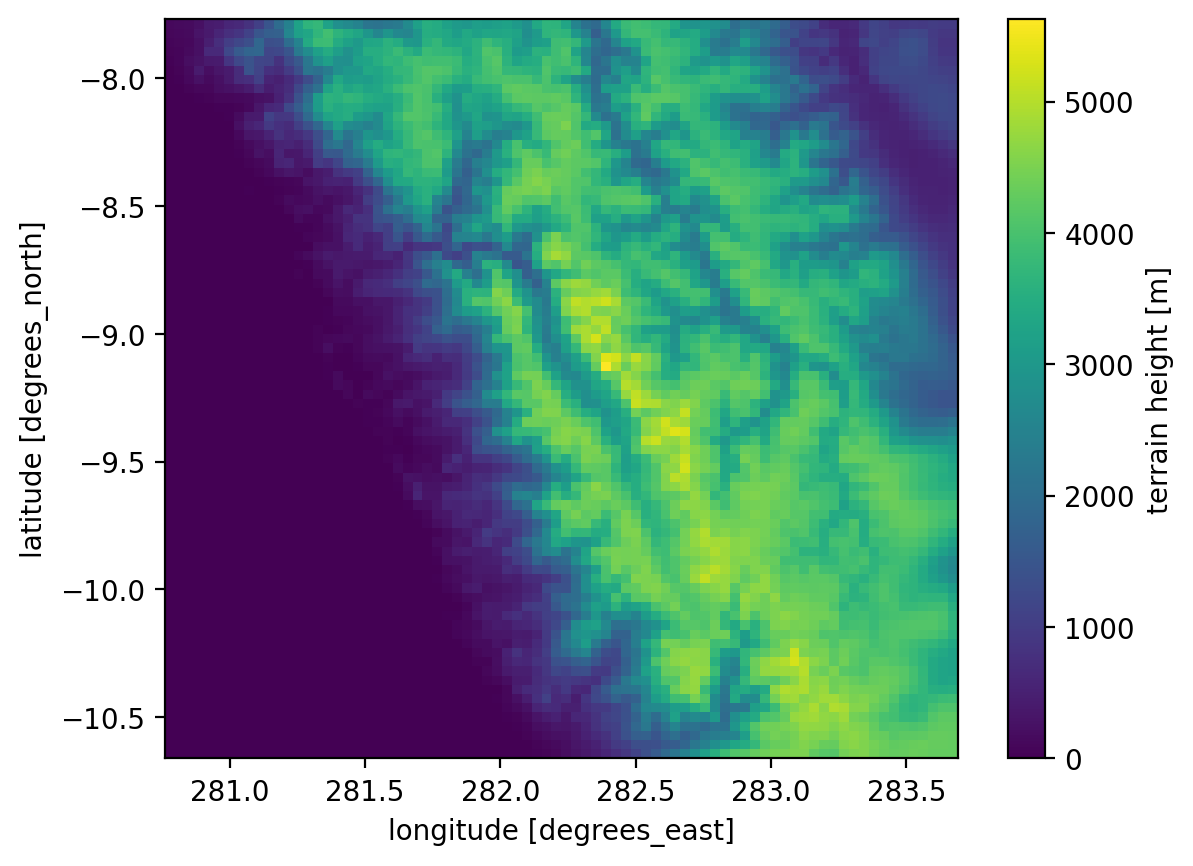

In [37]:
lo_ds_train.hgt.plot()

In [44]:

print(f'Training dataset (model input) sizes lo_ds_train -{lo_ds_train.sizes}')
print(f'Training targets (t2m) sizes hi_ds_train -{hi_ds_train.sizes}')

print(f'Validation dataset (model input) sizes lo_ds_valid -{lo_ds_valid.sizes}')
print(f'Validation targets (t2m) - sizes hi_ds_valid -{hi_ds_valid.sizes}')


Training dataset (model input) sizes lo_ds_train -Frozen({'time': 408, 'latitude': 80, 'longitude': 80})
Training targets (t2m) sizes hi_ds_train -Frozen({'latitude': 80, 'longitude': 80, 'time': 408})
Validation dataset (model input) sizes lo_ds_valid -Frozen({'time': 60, 'latitude': 80, 'longitude': 80})
Validation targets (t2m) - sizes hi_ds_valid -Frozen({'latitude': 80, 'longitude': 80, 'time': 60})


## Task 2: Make localised temperature predictions over the mountain regions from low-fidelity data

It is suggested that you use the hi-fidelity topography and (interpolated) low-fidelity T2m as inputs. You may also include other variables such as U/V wind, or extra variables that you can calculate or derive.

You may use a Deep Learning model, along with your preferred framework, or a standard Machine Learning model. You should be able to produce 2D - latitude/longitude predictions with your model.

Also, calculate the mean absolute error, across the 60 months in the validation dataset, as one of your metrics. Include some visualizations that highlight the errors in your predictions. 

You can submit either a python script for this task, or append your code to this notebook below. Additionally, please submit any visualisations either in this notebook or as separate .png files.


In [50]:
# KeysView(<xarray.Dataset>
# Dimensions:    (time: 408, latitude: 80, longitude: 80)
# Coordinates:
#   * time       (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2013-12-31
#   * latitude   (latitude) float32 -10.64 -10.61 -10.57 ... -7.859 -7.823 -7.787
#   * longitude  (longitude) float32 280.8 280.8 280.9 280.9 ... 283.6 283.6 283.7
# Data variables:
#     t2m        (time, latitude, longitude) float32 22.85 22.81 ... 23.03 22.95
#     u10        (time, latitude, longitude) float32 -2.306 -2.312 ... 0.06863
#     v10        (time, latitude, longitude) float32 4.747 4.747 ... -0.463
#     hgt        (latitude, longitude) float32 0.0 0.0 0.0 ... 995.7 984.1 970.5
# Attributes:
#     Description:  Low Fidelity Climate Model Output)

# 'hgt': Terrain height (high-fidelity only)
# 't2m': Near-surface temperature data (low- and high-fidelity data)
# 'u10', 'v10': East-ward & north-ward winds (low-fidelity only)


base = ['u10','v10','hgt']

df_features = lo_ds_train[base]

df_features = lo_ds_train.fillna(0)

df_features

<xarray.Dataset>
Dimensions:    (time: 408, latitude: 80, longitude: 80)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2013-12-31
  * latitude   (latitude) float32 -10.64 -10.61 -10.57 ... -7.859 -7.823 -7.787
  * longitude  (longitude) float32 280.8 280.8 280.9 280.9 ... 283.6 283.6 283.7
Data variables:
    t2m        (time, latitude, longitude) float32 22.85 22.81 ... 23.03 22.95
    u10        (time, latitude, longitude) float32 -2.306 -2.312 ... 0.06863
    v10        (time, latitude, longitude) float32 4.747 4.747 ... -0.463
    hgt        (latitude, longitude) float32 0.0 0.0 0.0 ... 995.7 984.1 970.5
Attributes:
    Description:  Low Fidelity Climate Model Output

In [59]:
# Inspecting the Data
for v in lo_ds_train:

    print("{}, {}, {}".format(v, lo_ds_train[v].attrs["long_name"], lo_ds_train[v].attrs["units"]))

t2m, 2 metre temperature, degrees_C
u10, 10 metre U wind component, m s-1
v10, 10 metre V wind component, m s-1
hgt, terrain height, m


In [78]:
# Filtering the xarray data to a specific variable
ds_t2m = lo_ds_train.get('t2m')
ds_t2m


# Converting the xarray data into a pandas.DataFrame
df_t2m = ds_t2m.to_dataframe()
df_t2m



t2m
time       latitude   longitude            
1980-01-31 -10.644470 280.777893  22.846292
                      280.814514  22.813698
                      280.851196  22.781046
                      280.887817  22.748451
                      280.924500  22.715799
...                                     ...
2013-12-31 -7.786659  283.526764  23.256174
                      283.563416  23.180323
                      283.600067  23.104471
                      283.636719  23.028620
                      283.673370  22.952768

[2611200 rows x 1 columns]

In [79]:
# Cropping the pandas.DataFrame to a geospatial bounding box
latitudes = df_t2m.index.get_level_values("latitude")
longitudes = df_t2m.index.get_level_values("longitude")

# Although latitude values are already in the standard range of -90 degress to +90 degrees, longitude values are in the range of 0 to +360.
# To make the data easier to work with, we convert longitude values into the standard range of -180 degrees to +180 degrees:
map_function = lambda longitude: (longitude - 360) if (longitude > 180) else longitude
remapped_longitudes = longitudes.map(map_function)

# With latitude and longitude data now in the desired value ranges, we can store them as new columns in our existing DataFrame:
df_t2m["longitude"] = remapped_longitudes
df_t2m["latitude"] = latitudes
df_t2m

t2m  longitude   latitude
time       latitude   longitude                                  
1980-01-31 -10.644470 280.777893  22.846292 -79.222107 -10.644470
                      280.814514  22.813698 -79.185486 -10.644470
                      280.851196  22.781046 -79.148804 -10.644470
                      280.887817  22.748451 -79.112183 -10.644470
                      280.924500  22.715799 -79.075500 -10.644470
...                                     ...        ...        ...
2013-12-31 -7.786659  283.526764  23.256174 -76.473236  -7.786659
                      283.563416  23.180323 -76.436584  -7.786659
                      283.600067  23.104471 -76.399933  -7.786659
                      283.636719  23.028620 -76.363281  -7.786659
                      283.673370  22.952768 -76.326630  -7.786659

[2611200 rows x 3 columns]

In [77]:
# The next step in the process is defining our geospatial bounding box, which we do by specifying the minimum and maximum coordinate values:
# https://gist.github.com/graydon/11198540
# 'PE': ('Peru', (-81.4109425524, -18.3479753557, -68.6650797187, -0.0572054988649)),
min_lat = -81.4109425524
max_lat = -18.3479753557
min_lon = -68.6650797187
max_lon = -0.0572054988649

# lat_filter = (df_t2m["latitude"] >= min_lat) & (df_t2m["latitude"] <= max_lat)
# lon_filter = (df_t2m["longitude"] >= min_lon) & (df_t2m["longitude"] <= max_lon)

# df_t2m = df_t2m.loc[lat_filter & lon_filter]
# df_t2m

#  The given data spans the same period (1980-01, to 2018-12) and regions (Peru, South America)
# So aboce code is not required

# df_t2m.to_csv("output_data.csv", index=False)


,,,t2m,longitude,latitude
time,latitude,longitude,,,


In [ ]:
# Filtering the xarray data to a specific variable
ds_u10 = lo_ds_train.get('u10')
ds_u10


# Converting the xarray data into a pandas.DataFrame
df_u10 = ds_u10.to_dataframe()
df_u10

In [64]:
# Filtering the xarray data to a specific variable
ds_v10 = lo_ds_train.get('v10')
ds_v10


# Converting the xarray data into a pandas.DataFrame
df_v10 = ds_v10.to_dataframe()
df_v10

v10
time       latitude   longitude           
1980-01-31 -10.644470 280.777893  4.747322
                      280.814514  4.747380
                      280.851196  4.747439
                      280.887817  4.747498
                      280.924500  4.747557
...                                    ...
2013-12-31 -7.786659  283.526764 -0.529134
                      283.563416 -0.512592
                      283.600067 -0.496050
                      283.636719 -0.479509
                      283.673370 -0.462967

[2611200 rows x 1 columns]

In [66]:
# Filtering the xarray data to a specific variable
ds_hgt = lo_ds_train.get('hgt')
ds_hgt


# Converting the xarray data into a pandas.DataFrame
df_hgt = ds_hgt.to_dataframe()
df_hgt

hgt
latitude   longitude             
-10.644470 280.777893    0.000000
           280.814514    0.000000
           280.851196    0.000000
           280.887817    0.000000
           280.924500    0.000000
...                           ...
-7.786659  283.526764  967.229614
           283.563416  962.599854
           283.600067  995.716553
           283.636719  984.147034
           283.673370  970.463501

[6400 rows x 1 columns]

In [56]:
df_hgt = lo_ds_train.get('hgt')
df_hgt

<xarray.DataArray 'hgt' (latitude: 80, longitude: 80)>
array([[   0.     ,    0.     ,    0.     , ..., 4280.768  , 4271.6562 ,
        4277.708  ],
       [   0.     ,    0.     ,    0.     , ..., 4287.8447 , 4298.0474 ,
        4279.151  ],
       [   0.     ,    0.     ,    0.     , ..., 4287.8447 , 4298.0474 ,
        4279.151  ],
       ...,
       [  71.39758,   97.95721,  130.88733, ..., 1000.92114,  856.09467,
         856.09467],
       [  90.84317,  116.17157,  142.52942, ...,  986.98413,  881.61865,
         880.7489 ],
       [ 113.29294,  140.04532,  161.88472, ...,  995.71655,  984.14703,
         970.4635 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -10.64 -10.61 -10.57 ... -7.859 -7.823 -7.787
  * longitude  (longitude) float32 280.8 280.8 280.9 280.9 ... 283.6 283.6 283.7
Attributes:
    units:          m
    standard_name:  orography
    long_name:      terrain height

In [51]:
X_train = df_features.values
X_train

<bound method Mapping.values of <xarray.Dataset>
Dimensions:    (time: 408, latitude: 80, longitude: 80)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2013-12-31
  * latitude   (latitude) float32 -10.64 -10.61 -10.57 ... -7.859 -7.823 -7.787
  * longitude  (longitude) float32 280.8 280.8 280.9 280.9 ... 283.6 283.6 283.7
Data variables:
    t2m        (time, latitude, longitude) float32 22.85 22.81 ... 23.03 22.95
    u10        (time, latitude, longitude) float32 -2.306 -2.312 ... 0.06863
    v10        (time, latitude, longitude) float32 4.747 4.747 ... -0.463
    hgt        (latitude, longitude) float32 0.0 0.0 0.0 ... 995.7 984.1 970.5
Attributes:
    Description:  Low Fidelity Climate Model Output>

### Input your code for tasks 2 here :)

Due to time restrictions and research into potential solutions, this assignment is only partially completed.

## Possible Approach
- After reading some literary works. In order to solve this issue, I advise following the recommendations made in the recent paper "Computationally-Efficient Climate Predictions using Multi-Fidelity Surrogate Modelling" (https://arxiv.org/abs/2109.07468)
- The goal is to use multi-fidelity surrogate modeling based on the Gaussian process to generate high-fidelity climate predictions at a reasonable cost. The authors used the same dataset to test the approach to produce high-fidelity temperature predictions for a mountainous region on the coastline of Peru.
 
### Software 
Emukit and GPy are two programs that can be used to implement the models. 
- Emukit (https://github.com/EmuKit/emukit) is a toolbox of diverse statistical emulation and multi-fidelity experimental design tools that is Python-based. 
- The Python program GPy (https://github.com/SheffieldML/GPy) is a framework for Gaussian processes.

## Task 3: Write a report
Write a short report (maximum one page) discussing your method and results, and why you took this approach. Include any problems/challenges that you faced and how you solved them. 

## Task 4: Bonus Question
How would you go about producing a probabilistic prediction or an ensemble of predictions? Discuss this in an additional second page in your report, but there's no need to actually attempt your approach. 